In [2]:
import os
import sys

In [3]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [4]:
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena

    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        root_dir = '..'
        %cd ..
    else:
        root_dir = '.'

c:\Users\alena\MyFolder\DIL\PatMatBaselineAlena


c:\Users\alena\MyFolder\DIL\PatMatBaselineAlena\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\alena\MyFolder\DIL\PatMatBaselineAlena


In [6]:
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), root_dir))
sys.path.append(current_dir)

In [7]:
# install requirements
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import json
from datetime import datetime
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import mlflow


c:\Users\alena\MyFolder\DIL\PatMatBaselineAlena\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD
)

In [10]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [11]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cpu')

In [13]:
# Type either "roberta-base" or 'bert-base-uncased' here
model_name = "roberta-base"

In [14]:
if model_name == "roberta-base":
    # Load the tokenizer
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    # Load the pre-trained ROBERTA model for sequence classification
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
else:
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load the pre-trained BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def print_memory_usage():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

In [16]:
print("Before loading model:")
print_memory_usage()

Before loading model:
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [17]:
# Move the model to the proper device
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [18]:
print("After loading model:")
print_memory_usage()

After loading model:
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [19]:
print(f"The maximum sequence length for this BERT model is: {tokenizer.model_max_length}")

The maximum sequence length for this BERT model is: 512


In [20]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train.jsonl')
validation_data = load_jsonl('data/validation.jsonl')
test_data = load_jsonl('data/test.jsonl')


# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]
test_texts = [(item['text'], item['text_b']) for item in test_data]
test_labels = [item['label'] for item in test_data]

In [21]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels), len(test_texts), len(test_labels)

(2304, 2304, 577, 577, 769, 769)

In [22]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:10]
    train_labels = train_labels[:10]
    validation_texts = validation_texts[:10]
    validation_labels = validation_labels[:10]
    test_texts = test_texts[:10]
    test_labels = test_labels[:10]

In [23]:
def explore_text_lengths(texts, index):
    mapping = {
        0: "Train set",
        1: "Validation set",
        2: "Test set"
    }
    
    print(f"{mapping[index]}")
    doc_lengths = [len((item[0] + " " + item[1]).split()) for item in texts]

    sorted_lengths = np.sort(doc_lengths)
    percentile_95_length = np.percentile(sorted_lengths, 95)
    print(f"The number of words at which 95% of the texts fit is: {percentile_95_length}")
    
    num_texts_below_given_length = np.sum(sorted_lengths <= 384)
    percentage_texts_below_given_length = (num_texts_below_given_length / len(sorted_lengths)) * 100
    print(f"The percentage of combined texts below 384 words (roughly 512 tokens) is: {percentage_texts_below_given_length:.2f}%")
    
    max_index = [(i, length) for (i, length) in enumerate(doc_lengths) if length > 380]
    print(f"The rough number of examples where combined text will be truncated (> 384 words (roughly 512 tokens)) is: {len(max_index)}")

    # Visualize the distribution of the lengths of the combined texts
    plt.hist(doc_lengths, bins=100)
    plt.axvline(percentile_95_length, color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of Combined Text Lengths, {mapping[index]}')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')
    plt.show()

Train set
The number of words at which 95% of the texts fit is: 356.2499999999999
The percentage of combined texts below 384 words (roughly 512 tokens) is: 90.00%
The rough number of examples where combined text will be truncated (> 384 words (roughly 512 tokens)) is: 1


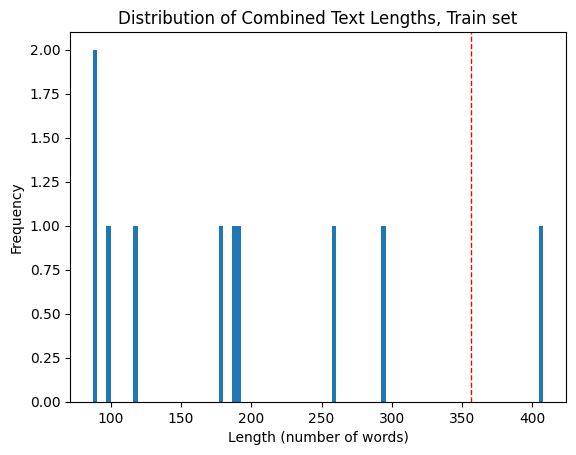

Validation set
The number of words at which 95% of the texts fit is: 351.94999999999993
The percentage of combined texts below 384 words (roughly 512 tokens) is: 100.00%
The rough number of examples where combined text will be truncated (> 384 words (roughly 512 tokens)) is: 1


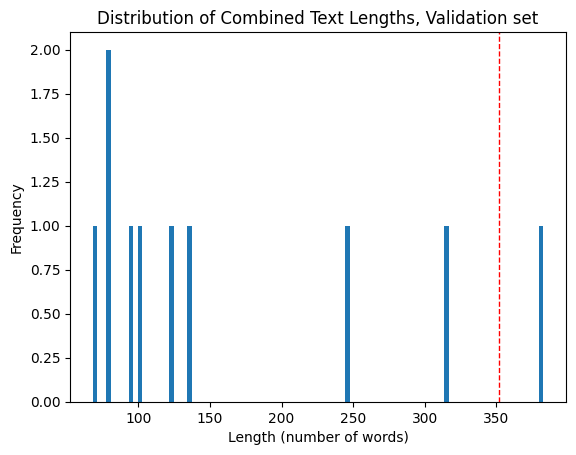

Test set
The number of words at which 95% of the texts fit is: 327.69999999999993
The percentage of combined texts below 384 words (roughly 512 tokens) is: 100.00%
The rough number of examples where combined text will be truncated (> 384 words (roughly 512 tokens)) is: 0


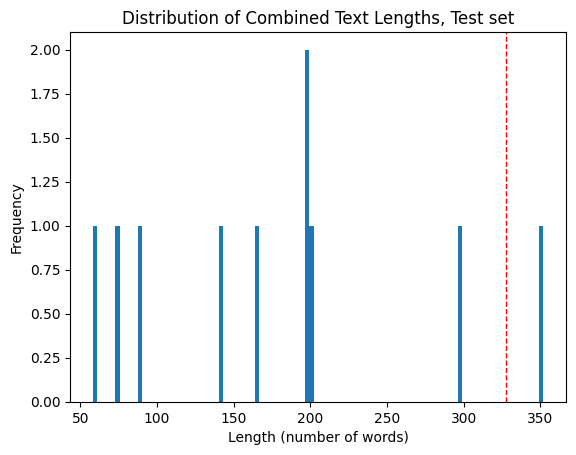

In [24]:
for i, texts in enumerate([train_texts, validation_texts, test_texts]):
    explore_text_lengths(texts, i)

In [25]:
config = {
    'learning_rate': 2e-5,
    'lr_scheduler': "StepLR",
    'gamma': 0.1,
    'step_size': 2,
    'batch_size': 32,
    'num_epochs': 4,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
    'base_model': model_name
}

In [26]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']

validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [27]:
decoded = tokenizer.decode(train_encodings["input_ids"][0])
print(decoded)
print(len(train_encodings["input_ids"][0]))
at_mask = train_encodings["attention_mask"][0]
print(at_mask)

<s>A hybrid vehicle characterized by comprising an internal combustion engine 2 a vehicle driving device 22 configured to generate a driving force for the hybrid vehicle by receiving electric power and generating electric power with power of the internal combustion engine a secondary battery 16 configured to input and output electric power to and from the vehicle driving device a current sensor 24 configured to detect a current input to and output from the secondary battery and a control device 26 configured to control charging and discharging of the secondary battery and configured to calculate an evaluation value showing a degree of deterioration of the secondary battery attributable to a salt concentration bias of the secondary battery resulting from the charging and discharging by using a value detected by the current sensor wherein the control device is further configured to execute a forced charging control by using the internal combustion engine and the vehicle driving device in

In [28]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape, test_input_ids.shape, test_attention_mask.shape

(torch.Size([10, 425]),
 torch.Size([10, 425]),
 torch.Size([10, 416]),
 torch.Size([10, 416]),
 torch.Size([10, 431]),
 torch.Size([10, 431]))

In [29]:
train_labels.shape, validation_labels.shape, test_labels.shape

(torch.Size([10]), torch.Size([10]), torch.Size([10]))

In [30]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)
test_data = TensorDataset(test_input_ids, test_attention_mask, test_labels)

In [31]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([10, 425]), torch.Size([10, 425]), torch.Size([10]))

In [32]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([10, 416]), torch.Size([10, 416]), torch.Size([10]))

In [33]:
test_data.tensors[0].shape, test_data.tensors[1].shape, test_data.tensors[2].shape

(torch.Size([10, 431]), torch.Size([10, 431]), torch.Size([10]))

In [34]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])
test_dataloader = DataLoader(test_data, batch_size=config["batch_size"])

In [35]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([10, 425]) torch.Size([10, 425]) torch.Size([10])


In [36]:
# Define the optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

In [37]:
user = MLFLOW_TRACKING_USERNAME
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [38]:
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [39]:
save_model = True

In [40]:
if save_model:
    model_save_path = f'models/{timestamp()}'

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

In [41]:
def calculate_and_log_train_metrics_and_hp(train_loss, epoch):
    # Log the average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss}")

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    mlflow.log_metric("learning_rate", current_lr, step=epoch)
    print(f"Current learning rate for epoch {epoch + 1}: {current_lr}")

In [42]:
def calculate_and_log_metrics(true_labels, predictions, epoch=None, test=False):
    step = "test" if test else "val"
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division='warn')
    recall = recall_score(true_labels, predictions, zero_division="warn")
    f1 = f1_score(true_labels, predictions, zero_division="warn")
    mcc = matthews_corrcoef(true_labels, predictions)

    # Log metrics
    mlflow.log_metric(f"{step}_accuracy", accuracy, step=epoch)
    mlflow.log_metric(f"{step}_precision", precision, step=epoch)
    mlflow.log_metric(f"{step}_recall", recall, step=epoch)
    mlflow.log_metric(f"{step}_f1", f1, step=epoch)
    mlflow.log_metric(f"{step}_mcc", mcc, step=epoch)

    print(f"{step} Accuracy: {accuracy}")
    print(f"{step} Precision: {precision}")
    print(f"{step} Recall: {recall}")
    print(f"{step} F1 Score: {f1}")
    print(f"{step} MCC: {mcc}")

In [43]:
def calculate_and_log_cm(true_labels, predictions, epoch=None, test=False):
    step = "test" if test else "val"
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predictions, normalize='true')
    cm_filename = f"artifacts/{step}_{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
    np.savetxt(cm_filename, cm, delimiter=",")
    mlflow.log_artifact(cm_filename)
    print(cm)

In [45]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    for param_name, param_value in config.items():
        mlflow.log_param(param_name, param_value)

    best_val_loss = float('inf')

    for epoch in range(config['num_epochs']):  # Number of training epochs
        print(f'############### Started {epoch + 1} epoch ###############')
        
        # Set run name
        mlflow.set_tag(key='mlflow.runName', value=f'{timestamp()}_{user}')
        
        print(f'Started training on {epoch + 1} epoch')
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()

        calculate_and_log_train_metrics_and_hp(train_loss, epoch)
        print(f'Finished training on {epoch + 1} epoch')

        # Validation loop
        print(f'Started validation on {epoch + 1} epoch')
        model.eval()
        val_loss = 0.0
        val_predictions, val_true_labels = [], []
        for batch in validation_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            val_predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
            val_true_labels.extend(b_labels.cpu().tolist())

        # Log the average validation loss for the epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss}")
    
        calculate_and_log_metrics(val_true_labels, val_predictions, epoch)
        
        # Save the best model based on validation loss
        if save_model:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model_to_save = model.module if hasattr(model, 'module') else model
                model_to_save.save_pretrained(model_save_path)
                tokenizer.save_pretrained(model_save_path)

        calculate_and_log_cm(val_true_labels, val_predictions, epoch)
        print(f'Finished validation on {epoch + 1} epoch')
        print(f'############### Finished {epoch + 1} epoch ###############\n')

        # Update the learning rate scheduler
        scheduler.step()
        
    # # Evaluate on the test set
    print(f'Started evaluation on test set')
    model.eval()
    test_loss = 0.0
    test_predictions, test_true_labels = [], []
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = batch

        # Move the batch to the proper device
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()

        test_predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
        test_true_labels.extend(b_labels.cpu().tolist())

    # Log the average test loss
    avg_test_loss = test_loss / len(test_dataloader)
    mlflow.log_metric("test_loss", avg_test_loss, config['num_epochs'])
    print(f"Average test loss: {avg_test_loss}")

    calculate_and_log_metrics(test_true_labels, test_predictions, config['num_epochs'], test=True)
    calculate_and_log_cm(test_true_labels, test_predictions, config['num_epochs'], test=True)
    
    print(f'Finished evaluation on test set')

mlflow.end_run()

############### Started 1 epoch ###############
Started training on 1 epoch
Average training loss for epoch 1: 0.5841337442398071
Current learning rate for epoch 1: 2.0000000000000004e-07
Finished training on 1 epoch
Started validation on 1 epoch
Average validation loss for epoch 1: 0.7312616109848022
val Accuracy: 0.4
val Precision: 0.4
val Recall: 1.0
val F1 Score: 0.5714285714285715
val MCC: 0.0
[[0. 1.]
 [0. 1.]]
Finished validation on 1 epoch
############### Finished 1 epoch ###############

############### Started 2 epoch ###############
Started training on 2 epoch
Average training loss for epoch 2: 0.5949198603630066
Current learning rate for epoch 2: 2.0000000000000004e-07
Finished training on 2 epoch
Started validation on 2 epoch
Average validation loss for epoch 2: 0.7315166592597961
val Accuracy: 0.4
val Precision: 0.4
val Recall: 1.0
val F1 Score: 0.5714285714285715
val MCC: 0.0
[[0. 1.]
 [0. 1.]]
Finished validation on 2 epoch
############### Finished 2 epoch #############